In [6]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn.functional as F
import os 

# On a multi-GPU system, this hides all GPUs except the first 
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

from torchvision import datasets, transforms

# Custom modules
from handsoncv.models import MnistClassifier
from handsoncv.training import _validate
from handsoncv.utils import set_seed

# Hardware & Paths
NOTEBOOK_DIR = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, "..", ".."))
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

# Folders we frequently use across the experiments' notebooks
ROOT_PATH = os.path.join(PROJECT_ROOT, "Assignment-3")
ROOT_DATA = os.path.join(ROOT_PATH, "data")
CHECKPOINTS_DIR = os.path.join(ROOT_PATH, "checkpoints")
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)

# Numpy and Torch Reproducibility
SEED=42
set_seed(42)

# Base Configuration Parameters
BATCH_SIZE = 1000

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda
Seeds set to 42 for reproducibility.


In [7]:
model = MnistClassifier().to(DEVICE)
model.load_state_dict(torch.load(f"{CHECKPOINTS_DIR}/mnist_cnn.pt"))
model

MnistClassifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [12]:
# Create a Generator object to pass to the dataLoaders
g = torch.Generator()
g.manual_seed(SEED)

test_kwargs = {'batch_size': BATCH_SIZE, 'num_workers': 2, 'pin_memory': True, 'shuffle': False}

# Base transforms used for Mnist Data
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

dataset = datasets.MNIST(ROOT_DATA, train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(dataset, **test_kwargs, generator=g)
print(f"Created test dataset containing {len(dataset)} samples")

Created test dataset containing 10000 samples


In [11]:
def _test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

_test(model, DEVICE, test_loader)


Test set: Average loss: 0.0265, Accuracy: 9917/10000 (99%)



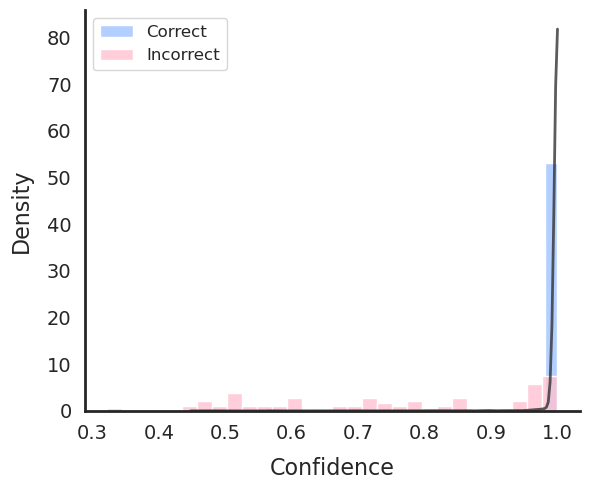

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def plot_confidence_distribution(model, loader, device):
    model.eval()
    correct_confidences = []
    incorrect_confidences = []

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            # Get actual probabilities
            probs = torch.exp(output) 
            conf, pred = torch.max(probs, dim=1)
            
            correct_mask = pred.eq(target)
            correct_confidences.extend(conf[correct_mask].cpu().numpy())
            incorrect_confidences.extend(conf[~correct_mask].cpu().numpy())

    # --- STYLING BLOCK ---
    sns.set_style("white") # White background
    plt.rcParams['figure.dpi'] = 100
    
    fig, ax = plt.subplots(figsize=(6, 5))
    
    # Define colors matching the image (Light Blue and Soft Pink/Purple)
    color_correct = "#A0C4FF" 
    color_incorrect = "#FFC2D1"

    # Plot Correct Predictions
    sns.histplot(correct_confidences, bins=30, kde=True, color=color_correct, 
                 label='Correct', stat="density", alpha=0.8, edgecolor=None)
    
    # Plot Incorrect Predictions
    sns.histplot(incorrect_confidences, bins=30, kde=False, color=color_incorrect, 
                 label='Incorrect', stat="density", alpha=0.8, edgecolor=None)

    # Styling the KDE lines (making them thick and dark like the image)
    for line in ax.lines:
        line.set_linewidth(2)
        line.set_color("#333333") # Dark charcoal gray
        line.set_alpha(0.8)

    # Match the "MOR" style Title and Axes
    ax.set_xlabel("Confidence", fontsize=16, labelpad=10)
    ax.set_ylabel("Density", fontsize=16, labelpad=10)
    
    # Thick axes lines and removing top/right spines
    sns.despine() # Removes top and right border
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    
    # Adjust tick thickness and size
    ax.tick_params(direction='out', length=6, width=2, labelsize=14)

    plt.legend(frameon=True, fontsize=12)
    plt.tight_layout()
    plt.show()

    return correct_confidences, incorrect_confidences

# Usage:
correct_scores, incorrect_scores = plot_confidence_distribution(model, test_loader, DEVICE)

In [72]:
def calculate_idk_metrics(correct_scores, incorrect_scores):
    thresholds = np.linspace(0.1, 1, 100)
    accuracies = []
    coverages = []
    
    total_samples = len(correct_scores) + len(incorrect_scores)
    
    for t in thresholds:
        # Which samples do we keep?
        accepted_correct = sum(1 for c in correct_scores if c >= t)
        accepted_incorrect = sum(1 for c in incorrect_scores if c >= t)
        
        total_accepted = accepted_correct + accepted_incorrect
        
        if total_accepted > 0:
            acc = accepted_correct / total_accepted
            cov = total_accepted / total_samples
        else:
            acc = 1.0 # If we accept nothing, we aren't "wrong"
            cov = 0.0
            
        accuracies.append(acc)
        coverages.append(cov)
        
    return thresholds, accuracies, coverages

# Run the sweep
thresholds, accuracies, coverages = calculate_idk_metrics(correct_scores, incorrect_scores)

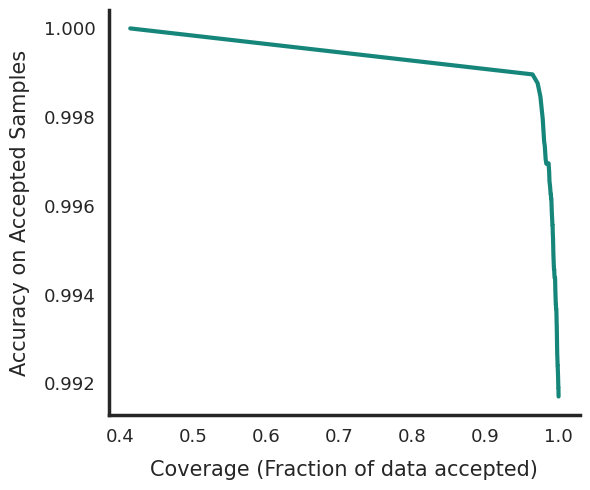

In [73]:
def plot_accuracy_coverage_curve(coverages, accuracies):
    # --- STYLING BLOCK ---
    sns.set_style("white")
    plt.rcParams['figure.dpi'] = 100
    
    fig, ax = plt.subplots(figsize=(6, 5))
    
    # Plot the line - using the dark charcoal gray from the previous KDE line
    ax.plot(coverages, accuracies, color="#16867B", linewidth=3, label='Model Performance')

    # Match the style: Title and Axes
    ax.set_xlabel("Coverage (Fraction of data accepted)", fontsize=15, labelpad=10)
    ax.set_ylabel("Accuracy on Accepted Samples", fontsize=15, labelpad=10)
    
    # Remove top and right spines
    sns.despine()
    
    # Make the left and bottom axes thicker
    ax.spines['left'].set_linewidth(2.5)
    ax.spines['bottom'].set_linewidth(2.5)
    
    # Adjust tick thickness and size to match
    ax.tick_params(direction='out', length=6, width=2.5, labelsize=13)
    
    # Add a subtle grid only for the Y axis to help read accuracy levels
    # ax.grid(axis='y', linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()
    
plot_accuracy_coverage_curve(coverages, accuracies)

In [88]:
# Find the threshold that yields 99.9% accuracy
target_accuracy = 0.9985
best_t = 0

for t, acc in zip(thresholds, accuracies):
    if acc >= target_accuracy:
        best_t = t
        break # We found the point where it starts dropping

print(f"Optimal Threshold for {target_accuracy*100}% accuracy: {best_t:.4f}")

Optimal Threshold for 99.85000000000001% accuracy: 0.9818


In [89]:
# How many errors would we have caught?
errors_caught = sum(1 for c in incorrect_scores if c < best_t)
total_errors = len(incorrect_scores)

# How many correct predictions would we "waste" by calling them IDK?
correct_rejected = sum(1 for c in correct_scores if c < best_t)
total_correct = len(correct_scores)

print(f"At threshold {best_t}:")
print(f"- Avoided {errors_caught}/{total_errors} errors ({errors_caught/total_errors:.1%})")
print(f"- Sacrificed {correct_rejected}/{total_correct} correct samples ({correct_rejected/total_correct:.1%})")

At threshold 0.9818181818181817:
- Avoided 71/83 errors (85.5%)
- Sacrificed 216/9917 correct samples (2.2%)


In [99]:
def predict_with_idk(model, loader, device, threshold=0.9):
    model.eval()
    results = []
    
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            output = model(data)
            
            # Convert logits to probabilities
            probs = F.softmax(output, dim=1)
            
            # Get max probability and its index
            max_probs, preds = torch.max(probs, dim=1)
            
            for i in range(len(preds)):
                conf = max_probs[i].item()
                label = preds[i].item()
                
                # Apply IDK Logic
                final_label = label if conf >= threshold else "IDK"
                
                results.append({
                    "prediction": final_label,
                    "confidence": conf,
                    "ground_truth": target[i].item()
                })
    return results

In [101]:
import fiftyone as fo
import fiftyone.zoo as foz

# Clean up existing datasets to avoid slug/name conflict
fiftyone_dataset_name = "mnist_idk_experiment"
if fiftyone_dataset_name in fo.list_datasets():
    fo.delete_dataset(fiftyone_dataset_name)

# Load MNIST from the Zoo: this automatically handles the binary files and creates the PNGs FiftyOne needs
dataset = foz.load_zoo_dataset(
    "mnist",
    split="test",
    dataset_name=fiftyone_dataset_name,
)

# Generate predictions using existing model using threshold we selected (0.9818)
IDK_THRESHOLD = 0.9818
results = predict_with_idk(model, test_loader, DEVICE, threshold=IDK_THRESHOLD)

# Add the predictions to the FiftyOne dataset
# The Zoo MNIST and Torchvision MNIST 'test' splits are ordered identically
samples = dataset.sort_by("filepath")

print("Applying IDK predictions to FiftyOne...")
for sample, res in zip(samples, results):
    label = str(res["prediction"])
    
    # Add the classification
    sample["idk_model"] = fo.Classification(
        label=label,
        confidence=res["confidence"]
    )
    
    # Add a boolean field for easy filtering in the UI
    sample["is_idk"] = (label == "IDK")
    
    # Compare with ground truth to see if the model was right to say IDK
    # (Optional, but helpful for your report)
    sample.save()

# Launch the App
session = fo.launch_app(dataset)

Split 'test' already downloaded
Loading 'mnist' split 'test'
 100% |█████████████| 10000/10000 [4.4s elapsed, 0s remaining, 2.3K samples/s]      
Dataset 'mnist_idk_experiment' created
Applying IDK predictions to FiftyOne...


In [102]:
# Define the export path and a metadata.jsonl file so the scores show up in the table
export_dir = os.path.join(ROOT_DATA, "mnist_idk_evaluation_export")

# Perform the export
# This creates a folder containing:
# - data/ (the images)
# - samples.json (all metrics: clip_score, uniqueness, representativeness, embeddings)
# - metadata.json (dataset info)
dataset.export(
    export_dir=export_dir,
    dataset_type=fo.types.FiftyOneDataset,
    export_media=True
)

print(f"FiftyOne dataset exported to {export_dir}")

Exporting samples...
 100% |████████████████| 10000/10000 [1.9s elapsed, 0s remaining, 6.7K docs/s]        
FiftyOne dataset exported to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-3/data/mnist_idk_evaluation_export
